<a href="https://colab.research.google.com/github/GabrielRamirezs/Metodos1_KarenQuevedo_GabrielRamirez/blob/main/Parcial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

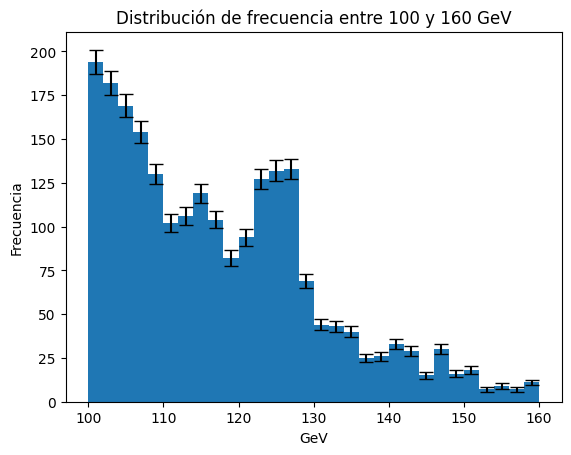

<ipython-input-4-c0e2dd318acd>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_likelihood += -1 * math.log(hipotesis_nula(α, xi))


In [ ]:
#10
import math
from scipy.optimize import minimize

url ="https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/HiggsFitting.csv"
data= pd.read_csv(url, header=None)

data[0] = pd.to_numeric(data[0], errors='coerce')
filtered_data = data[(data[0] >= 100) & (data[0] <= 160)][0].values

n, bins, patches = plt.hist(filtered_data, bins=30, range=(100, 160))

bin_centers = 0.5 * (bins[:-1] + bins[1:])
error = 0.5*np.sqrt(n)
plt.errorbar(bin_centers, n, yerr=error, fmt='none', ecolor='k', capsize=5)

plt.xlabel('GeV')
plt.ylabel('Frecuencia')
plt.title('Distribución de frecuencia entre 100 y 160 GeV')
plt.show()

def hipotesis_nula(x,α):
  return (1/α)*np.exp((-x+100)/α)

def negative_log_likelihood(α, x, hipotesis_nula):
    n = len(x)
    log_likelihood = 0
    for xi in x:
        log_likelihood += -1 * math.log(hipotesis_nula(α, xi))
    return log_likelihood
bounds = ((0, 50),)
x0=1
resultado = minimize(lambda alpha: negative_log_likelihood(alpha, filtered_data, hipotesis_nula), x0, bounds=bounds)

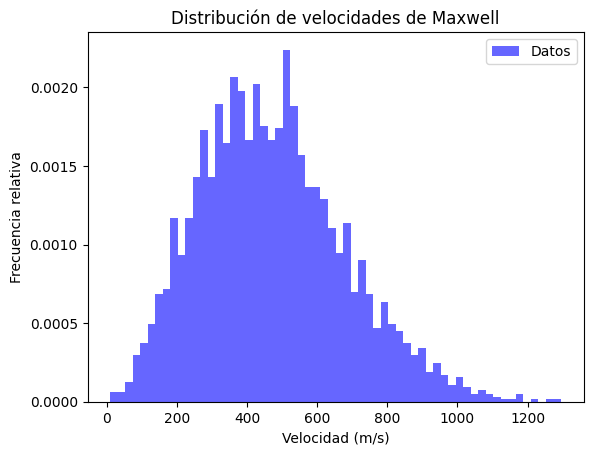

Velocidad promedio empírica: 472.15 m/s
Temperatura ajustada: 295.91 K
Velocidad más probable: 419.11 m/s
Velocidad promedio (teórica): 472.91 m/s


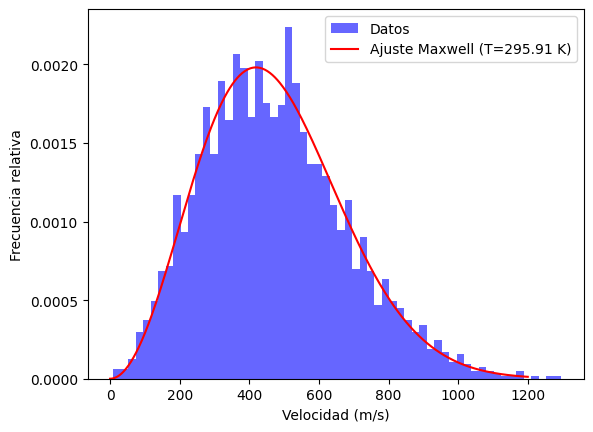

Velocidad cuadrática media: 513.30 m/s


In [3]:
#9
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

url = "https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/Maxwell.csv"
data = pd.read_csv(url, header=None)
velocities = pd.to_numeric(data[0], errors='coerce').dropna().values

bins = 60
freq, edges = np.histogram(velocities, bins=bins, density=True)
bin_centers = (edges[:-1] + edges[1:]) / 2

plt.hist(velocities, bins=bins, density=True, alpha=0.6, color='blue', label='Datos')
plt.xlabel('Velocidad (m/s)')
plt.ylabel('Frecuencia relativa')
plt.title('Distribución de velocidades de Maxwell')
plt.legend()
plt.show()

velocity_mean_empirical = np.sum(bin_centers * freq * np.diff(edges))
print(f"Velocidad promedio empírica: {velocity_mean_empirical:.2f} m/s")

def maxwell_distribution(v, T):
    m = 0.028 / 6.022e23
    k_B = 1.38e-23
    return 4 * np.pi * (m / (2 * np.pi * k_B * T))**1.5 * v**2 * np.exp(-m * v**2 / (2 * k_B * T))

T_initial = 300
popt, _ = curve_fit(lambda v, T: maxwell_distribution(v, T), bin_centers, freq, p0=[T_initial])
T_best_fit = popt[0]
print(f"Temperatura ajustada: {T_best_fit:.2f} K")

v_probable = np.sqrt(2 * 1.38e-23 * T_best_fit / (0.028 / 6.022e23))
print(f"Velocidad más probable: {v_probable:.2f} m/s")

v_avg = np.sqrt(8 * 1.38e-23 * T_best_fit / (np.pi * (0.028 / 6.022e23)))
print(f"Velocidad promedio (teórica): {v_avg:.2f} m/s")

v_model = np.linspace(0, 1200, 500)
pdf_model = maxwell_distribution(v_model, T_best_fit)

plt.hist(velocities, bins=bins, density=True, alpha=0.6, color='blue', label='Datos')
plt.plot(v_model, pdf_model, 'r-', label=f'Ajuste Maxwell (T={T_best_fit:.2f} K)')
plt.xlabel('Velocidad (m/s)')
plt.ylabel('Frecuencia relativa')
plt.legend()
plt.show()

v_rms = np.sqrt(3 * 1.38e-23 * T_best_fit / (0.028 / 6.022e23))
print(f"Velocidad cuadrática media: {v_rms:.2f} m/s")

In [ ]:
!pip install emcee
!pip install corner

In [ ]:
#10

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner

url = "https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/HiggsFitting.csv"
data = pd.read_csv(url, header=None)


data[0] = pd.to_numeric(data[0], errors='coerce')
data = data.dropna()


filtered_data = data[(data[0] >= 100) & (data[0] <= 160)][0].values


n, bins, patches = plt.hist(filtered_data, bins=30, range=(100, 160), alpha=0.6, label='Datos')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
error = 0.5 * np.sqrt(n)
plt.errorbar(bin_centers, n, yerr=error, fmt='none', ecolor='k', capsize=5)
plt.xlabel('GeV')
plt.ylabel('Frecuencia')
plt.title('Distribución de frecuencia entre 100 y 160 GeV')
plt.legend()
plt.show()


def hipotesis_nula(x, α):
    return (1/α) * np.exp((-x + 100)/α)

def hipotesis_alternativa(A, mu, sigma, alpha, x):
    signal = A * (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(- (x - mu)**2 / (2 * sigma**2))
    background = (1 - A) * (1 / alpha) * np.exp(- (x - 100) / alpha)
    return signal + background

def negative_log_likelihood_nula(α, x):
    log_likelihood = 0
    for xi in x:
        p = hipotesis_nula(xi, α)
        if p > 0:
            log_likelihood += -1 * np.log(p)
        else:
            log_likelihood += 1e6
    return log_likelihood

bounds_nula = [(1, 100)]
x0_nula = [50]

resultado_nula = minimize(negative_log_likelihood_nula, x0_nula, args=(filtered_data,), bounds=bounds_nula)
alpha_optimo = resultado_nula.x[0]
print(f"Valor óptimo de α para la hipótesis nula: {alpha_optimo}")

def negative_log_likelihood_alternativa(params, x):
    A, mu, sigma, alpha = params
    log_likelihood = 0
    for xi in x:
        p = hipotesis_alternativa(A, mu, sigma, alpha, xi)
        if p > 0:
            log_likelihood += -1 * np.log(p)
        else:
            log_likelihood += 1e6
    return log_likelihood

bounds_alternativa = [(0, 1), (50, 500), (1, 100), (1, 100)]
x0_alternativa = [0.5, 125, 2, 10]

resultado_alternativa = minimize(negative_log_likelihood_alternativa, x0_alternativa, args=(filtered_data,), bounds=bounds_alternativa)

A_optimo, mu_optimo, sigma_optimo, alpha_alt_optimo = resultado_alternativa.x
print(f"Valor óptimo de A: {A_optimo}")
print(f"Valor óptimo de µ: {mu_optimo}")
print(f"Valor óptimo de σ: {sigma_optimo}")
print(f"Valor óptimo de α para la hipótesis alternativa: {alpha_alt_optimo}")

plt.hist(filtered_data, bins=30, range=(100, 160), alpha=0.6, label='Datos')
x_values = np.linspace(100, 160, 1000)

y_values_nula = len(filtered_data) * (x_values[1] - x_values[0]) * hipotesis_nula(x_values, alpha_optimo)
plt.plot(x_values, y_values_nula, label='Modelo (hipótesis nula)', color='blue')

y_values_alternativa = len(filtered_data) * (x_values[1] - x_values[0]) * hipotesis_alternativa(A_optimo, mu_optimo, sigma_optimo, alpha_alt_optimo, x_values)
plt.plot(x_values, y_values_alternativa, label='Modelo (hipótesis alternativa)', color='red')

plt.xlabel('GeV')
plt.ylabel('Frecuencia')
plt.title('Datos y Modelos de Hipótesis Nula y Alternativa')
plt.legend()
plt.show()

log_likelihood_nula = negative_log_likelihood_nula(alpha_optimo, filtered_data)
log_likelihood_alternativa = negative_log_likelihood_alternativa([A_optimo, mu_optimo, sigma_optimo, alpha_alt_optimo], filtered_data)
n_sigma = np.sqrt(-2 * (log_likelihood_alternativa - log_likelihood_nula))
print(f"Número de desviaciones estándar (nσ): {n_sigma}")

hbar = 1.015e-23  
sigma_joules = sigma_optimo * 1.60218e-10  
tau = hbar / sigma_joules
print(f"Tiempo de vida de la partícula (τ): {tau} s")

def LogPrior(p):
    A, mu, sigma, alpha = p
    if 0 < A < 1 and 100 <= mu <= 300 and 0.1 <= sigma <= 20 and 1 <= alpha <= 50:
        return 0
    else:
        return -np.inf

def LogLikelihood(p, x):
    A, mu, sigma, alpha = p
    log_likelihood = 0
    for xi in x:
        p = hipotesis_alternativa(A, mu, sigma, alpha, xi)
        if p > 0:
            log_likelihood += np.log(p)
    return log_likelihood

def LogPosterior(p, x):
    lp = LogPrior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + LogLikelihood(p, x)

ndim = 4 
nwalkers = 50  
nsteps = 1000  
initial = [0.5, 125, 2, 10]  
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[filtered_data])
sampler.run_mcmc(p0, nsteps, progress=True)

samples = sampler.get_chain(discard=100, thin=15, flat=True)

fig = corner.corner(samples, labels=["A", "μ", "σ", "α"], truths=[0.5, 125, 2, 10])
plt.show()

A_mcmc, mu_mcmc, sigma_mcmc, alpha_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                                                zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print(f"A: {A_mcmc[0]:.3f} (+{A_mcmc[1]:.3f}/-{A_mcmc[2]:.3f})")

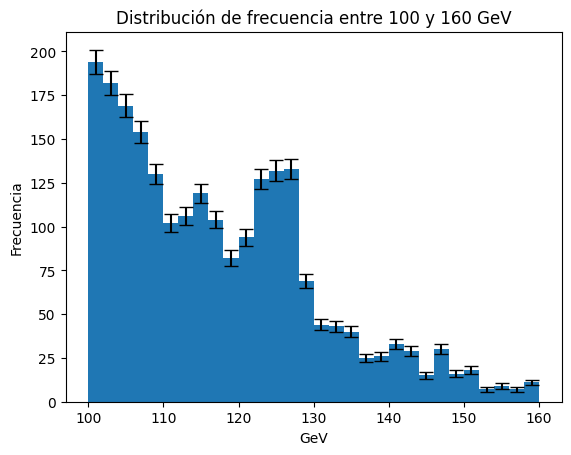

<ipython-input-4-c0e2dd318acd>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_likelihood += -1 * math.log(hipotesis_nula(α, xi))


In [4]:
#10
import math
from scipy.optimize import minimize

url ="https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/HiggsFitting.csv"
data= pd.read_csv(url, header=None)

data[0] = pd.to_numeric(data[0], errors='coerce')
filtered_data = data[(data[0] >= 100) & (data[0] <= 160)][0].values

n, bins, patches = plt.hist(filtered_data, bins=30, range=(100, 160))

bin_centers = 0.5 * (bins[:-1] + bins[1:])
error = 0.5*np.sqrt(n)
plt.errorbar(bin_centers, n, yerr=error, fmt='none', ecolor='k', capsize=5)

plt.xlabel('GeV')
plt.ylabel('Frecuencia')
plt.title('Distribución de frecuencia entre 100 y 160 GeV')
plt.show()

def hipotesis_nula(x,α):
  return (1/α)*np.exp((-x+100)/α)

def negative_log_likelihood(α, x, hipotesis_nula):
    n = len(x)
    log_likelihood = 0
    for xi in x:
        log_likelihood += -1 * math.log(hipotesis_nula(α, xi))
    return log_likelihood
bounds = ((0, 50),)
x0=1
resultado = minimize(lambda alpha: negative_log_likelihood(alpha, filtered_data, hipotesis_nula), x0, bounds=bounds)

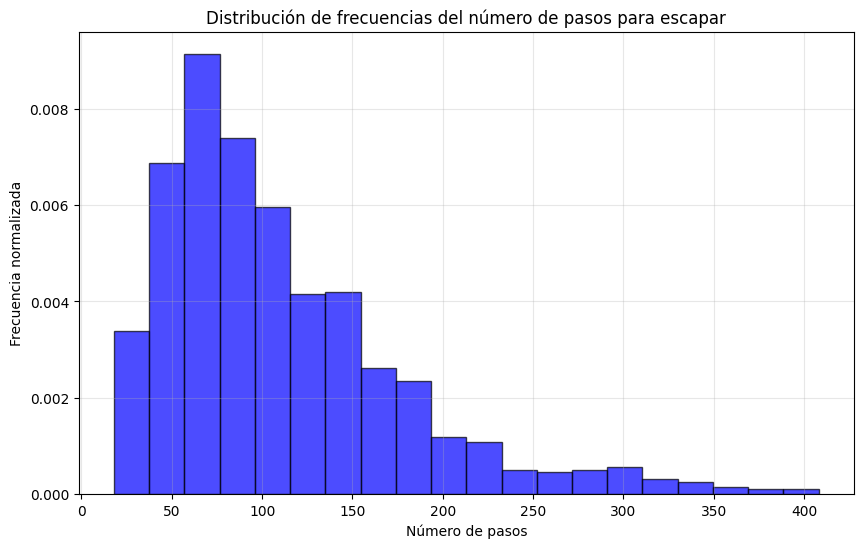

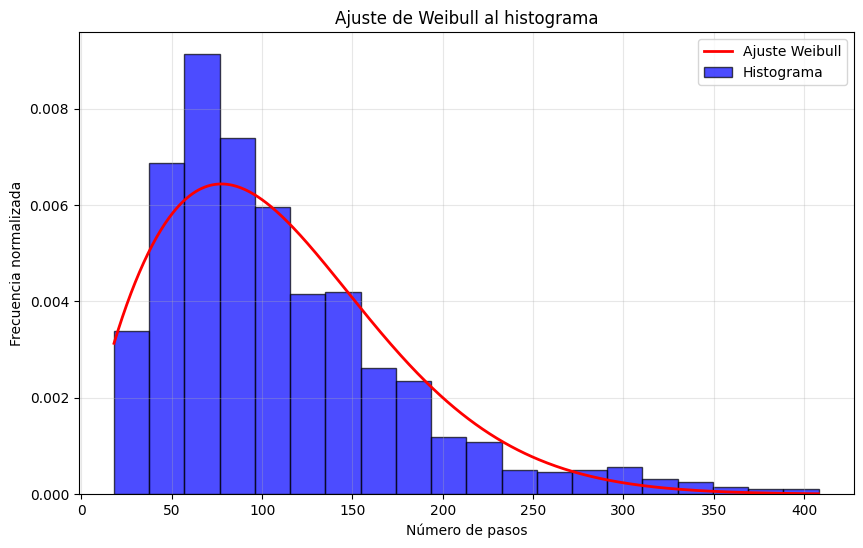

(100.0, 6.976386036960986e-17, (1.769824829478982, 123.9129808754163))

In [7]:
#4
import numpy as np
import matplotlib.pyplot as plt

l = 0.1
Rs = 1.0
N = 1000
num_classes = 20

def random_step(x, y, z):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)
    dx = l * np.sin(theta) * np.cos(phi)
    dy = l * np.sin(theta) * np.sin(phi)
    dz = l * np.cos(theta)
    return x + dx, y + dy, z + dz

def simulate_escape():
    x, y, z = 0.0, 0.0, 0.0
    steps = 0
    while np.sqrt(x**2 + y**2 + z**2) <= Rs:
        x, y, z = random_step(x, y, z)
        steps += 1
    return steps
steps_list = [simulate_escape() for _ in range(N)]
min_steps, max_steps = min(steps_list), max(steps_list)
bins = np.linspace(min_steps, max_steps, num_classes + 1)
hist, edges = np.histogram(steps_list, bins=bins, density=True)
class_centers = (edges[:-1] + edges[1:]) / 2
expected_steps = np.sum(hist * class_centers * np.diff(edges))

plt.figure(figsize=(10, 6))
plt.bar(class_centers, hist, width=np.diff(edges), alpha=0.7, color="blue", edgecolor="black")
plt.xlabel("Número de pasos")
plt.ylabel("Frecuencia normalizada")
plt.title("Distribución de frecuencias del número de pasos para escapar")
plt.grid(alpha=0.3)
plt.show()
min_steps, max_steps, expected_steps

from scipy.stats import exponweib

theoretical_steps = (Rs / l) ** 2

Rs_km = 700000
c_kms = 300000
l_cm = 0.6

l_km = l_cm * 1e-5
time_per_collision = l_km / c_kms
total_time_seconds = expected_steps * time_per_collision
total_time_years = total_time_seconds / (60 * 60 * 24 * 365.25)

params = exponweib.fit(steps_list, floc=0, f0=1)
shape, scale = params[1], params[3]

x_fit = np.linspace(min_steps, max_steps, 500)
pdf_fit = exponweib.pdf(x_fit, *params)
plt.figure(figsize=(10, 6))
plt.bar(class_centers, hist, width=np.diff(edges), alpha=0.7, label="Histograma", color="blue", edgecolor="black")
plt.plot(x_fit, pdf_fit, 'r-', label="Ajuste Weibull", linewidth=2)
plt.xlabel("Número de pasos")
plt.ylabel("Frecuencia normalizada")
plt.title("Ajuste de Weibull al histograma")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

theoretical_steps, total_time_years, (shape, scale)
